<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png' width=250px>

In [1]:
import talos as ta
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


## Table of Contents

##### 1. <a href=#one>Data Preparation</a>
##### 2. <a href=#two>Model Preparation</a>
##### 3. <a href=#three>Setting the Parameter Space Boundaries</a>
##### 4. <a href=#four>Run the Hyperparameter <code>Scan()</code></a>
##### 5. <a href=#five>Access the results through the <code>Scan</code> object</a>
##### 6. <a href=#six>Analysing the Scan results with <code>Reporting()</code></a>
##### 7. <a href=#seven>Evaluating Models with <code>Evaluate()</code></a>
##### 8. <a href=#eight>Deploying Models with <code>Deploy()</code></a>
##### 9. <a href=#nine>Restoring Models with <code>Restore()</code></a>

### 1. Data Preparation <a name="one"></a> 

For this experiment, we're going to use the famous Iris dataset. 

In [3]:
x, y = ta.templates.datasets.iris()

### 2. Model Preparation  <a name="two"></a> 
Talos works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works. 

For this example, we have to import two helper functions from Talos, one for early stopping callout, and the other for using normalized learning rate values. Because we might want to work on trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome.

In [4]:
from talos.model.normalizers import lr_normalizer

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels.

In [5]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

def iris_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()                            
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    activation='relu'))
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(y_train.shape[1],
                    activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
    
    return out, model

### 3. Setting the Parameter Space Boundaries <a name="three"></a> 
In the last and final step, we're going to create the dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

In [12]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

p = {'lr': (0.1, 10, 3),
     'first_neuron':[4, 8],#, 16, 32, 64, 128],
     'batch_size': [2, 3],#, 4],
     'epochs': [200],
     'dropout': (0, 0.40, 3),
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'last_activation': ['softmax'],
     'weight_regulizer': [None]}

### 4. Run the Hyperparameter <code>Scan()</code> <a name="four"></a> 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/100 of the entire permutations.

In [13]:
h = ta.Scan(x, y, params=p,
            model=iris_model)


 17%|█▋        | 12/72 [02:49<14:34, 14.57s/it]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



100%|██████████| 72/72 [16:01<00:00, 11.57s/it]

### 5. Access the results through the <code>Scan</code> object <a name="five"></a> 

In [17]:
# accessing the results data frame
h.data.head()

# accessing epoch entropy values for each round
# h.peak_epochs_df

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,first_neuron,last_activation,loss,lr,optimizer,weight_regulizer
0,200,0.445675,0.955556,0.467169,0.980952,2,0.0,200,4,softmax,categorical_crossentropy,0.1,<class 'keras.optimizers.Adam'>,None
1,200,0.227696,0.977778,0.245573,0.961905,2,0.0,200,4,softmax,categorical_crossentropy,0.1,<class 'keras.optimizers.Nadam'>,None
2,200,0.096420,0.955556,0.054689,0.971429,2,0.0,200,4,softmax,categorical_crossentropy,3.4,<class 'keras.optimizers.Adam'>,None
3,200,0.145895,0.933333,0.042369,0.971429,2,0.0,200,4,softmax,categorical_crossentropy,3.4,<class 'keras.optimizers.Nadam'>,None
4,200,0.063435,0.977778,0.050865,0.971429,2,0.0,200,4,softmax,categorical_crossentropy,6.7,<class 'keras.optimizers.Adam'>,None


In [16]:
# access the summary details
h.details

experiment_name            071219201535
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            07/12/19/20:31
x_shape                        (150, 4)
y_shape                        (150, 3)
dtype: object

In addition to statistics and meta-data related with the Scan, the used data (x and y) together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object. 

In [19]:
# accessing the saved models
# h.saved_models

In [21]:
# accessing the saved weights for models
# h.saved_weights

The Scan object can be further used, and is required, as input for Predict(), Evaluate(), and Deploy(). More about this in the corresponding sections below.

### 6. Analysing the Scan results with <code>Reporting()</code> <a name="six"></a> 

In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object. 

In [22]:
# use Scan object as input
r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('iris_1.csv')

In [23]:
# access the dataframe with the results
r.data.head(-3)

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,batch_size,epochs,dropout,optimizer,loss.1,last_activation,weight_regulizer
0,200,0.044435,1.000000,0.079879,0.980952,9.01,16,2,200,0.24,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None
1,200,0.043197,1.000000,0.064164,0.990476,4.06,32,2,200,0.36,<class 'keras.optimizers.Adam'>,categorical_crossentropy,softmax,None
2,200,0.040054,1.000000,0.045489,0.990476,3.07,128,2,200,0.16,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None
3,200,0.049635,1.000000,0.055599,0.990476,1.09,128,4,200,0.36,<class 'keras.optimizers.Adam'>,categorical_crossentropy,softmax,None
4,200,0.167790,1.000000,0.246879,0.914286,7.03,4,2,200,0.28,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None
5,200,0.043224,1.000000,0.042622,0.990476,7.03,128,3,200,0.04,<class 'keras.optimizers.Adam'>,categorical_crossentropy,softmax,None
6,200,0.043211,1.000000,0.046532,0.990476,5.05,64,4,200,0.08,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None
7,200,0.042335,1.000000,0.072455,0.980952,5.05,16,3,200,0.20,<class 'keras.optimizers.Adam'>,categorical_crossentropy,softmax,None
8,200,0.041708,1.000000,0.047114,0.990476,7.03,8,4,200,0.04,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None
9,200,0.042283,1.000000,0.077207,0.980952,2.08,16,3,200,0.36,<class 'keras.optimizers.Nadam'>,categorical_crossentropy,softmax,None


In [ ]:
# get the number of rounds in the Scan
r.rounds()

# get the highest result ('val_acc' by default)
r.high()

# get the highest result for any metric
r.high('acc')

# get the round with the best result
r.rounds2high()

# get the best paramaters
r.best_params()

# get correlation for hyperparameters against a metric
r.correlate('val_loss')

In [31]:
# get the best paramaters
r.best_params()

array([[9.01, 'softmax', 0.24, "<class 'keras.optimizers.Nadam'>",
        'categorical_crossentropy', 16, 200, 'None', 2, 0],
       [7.03, 'softmax', 0.2, "<class 'keras.optimizers.Adam'>",
        'categorical_crossentropy', 8, 200, 'None', 3, 1],
       [6.04, 'softmax', 0.36, "<class 'keras.optimizers.Nadam'>",
        'categorical_crossentropy', 16, 200, 'None', 4, 2],
       [5.05, 'softmax', 0.04, "<class 'keras.optimizers.Adam'>",
        'categorical_crossentropy', 16, 200, 'None', 4, 3],
       [6.04, 'softmax', 0.2, "<class 'keras.optimizers.Nadam'>",
        'categorical_crossentropy', 64, 200, 'None', 3, 4],
       [7.03, 'softmax', 0.32, "<class 'keras.optimizers.Adam'>",
        'categorical_crossentropy', 4, 200, 'None', 2, 5],
       [4.0600000000000005, 'softmax', 0.24,
        "<class 'keras.optimizers.Adam'>", 'categorical_crossentropy',
        16, 200, 'None', 4, 6],
       [3.0700000000000003, 'softmax', 0.0,
        "<class 'keras.optimizers.Nadam'>", 'categori

In addition to the key obsevations, several useful plots are available for analysis of the results.

In [ ]:
# a regression plot for two dimensions 
r.plot_regs()

# line plot
r.plot_line()

# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

# a simple histogram
r.plot_hist(bins=50)

# heatmap correlation
r.plot_corr()

# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

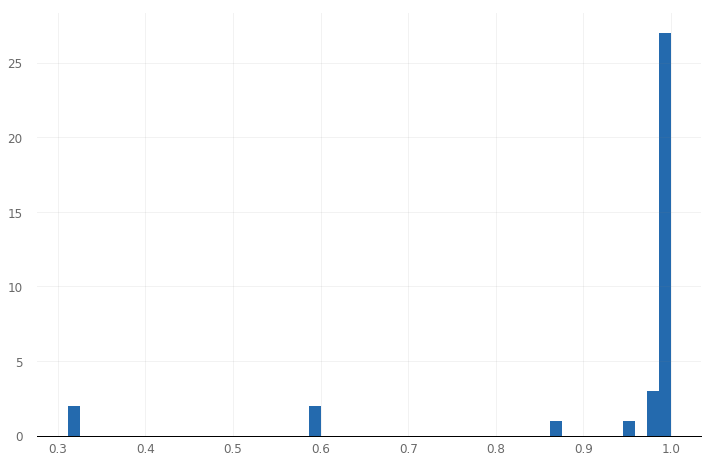

In [28]:
# a four dimensional bar grid
r.plot_hist(bins=50)

### 7. Evaluating Models with <code>Evaluate()</code> <a name="seven"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [ ]:
e = ta.Evaluate(h)
e.evaluate(x, y, folds=10, average='macro')

Once a sufficiently performing model have been found, a deployment package can be easily created.

### 8. Deploying Models with <code>Deploy()</code> <a name="eight"></a> 

Once the right model or models have been found, you can create a deployment package with <code>Deploy()</code> which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of: 

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

The <code>Deploy</code> package can be easily restored with <code>Restore()</code> which is covered in the next section.

In [ ]:
ta.Deploy(h, 'iris');

### 9. Restoring Models with <code>Restore()</code> <a name="nine"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [ ]:
iris = ta.Restore('iris.zip')

The <code>Restore</code> object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In [ ]:
# make predictions with the model
iris.model.predict(x)

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the <code>Restore</code> object:

In [ ]:
# get the meta-data for the experiment
iris.details

In [ ]:
# get the hyperparameter space boundary
iris.params

In [ ]:
# sample of x and y data
iris.x
iris.y

In [ ]:
# the results dataframe
iris.results


<img align=left src='https://img00.deviantart.net/920c/i/2014/137/a/2/pinkie_pie_thats_all_folks_by_dan232323-d7ipnd4.jpg' width=400>

Back to the repository page >> http://github.com/autonomio/talos